# Imports

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Funktionen

In [92]:
def plot_scatter(c1: np.ndarray, c2: np.ndarray, c1_label: str, c2_label: str):
    plt.scatter(c1[:, 0], c1[:, 1], label=c1_label)
    plt.scatter(c2[:, 0], c2[:, 1], label=c2_label)
    plt.legend()
    plt.show()

def generate_dataset(c1: np.ndarray, c2: np.ndarray, test_size: float = 0.3):
    x = np.concatenate([c1, c2], axis=0)
    y = np.concatenate([np.zeros(c1.shape[0]), np.ones(c2.shape[0])], axis=0)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    return x, y, x_train, x_test, y_train, y_test

def get_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    prec = cm / cm.sum() * 100
    prec_score = (cm[0, 1] + cm[1, 0]) / cm.sum() * 100
    return cm, prec, prec_score

def plot_cm(prec, title):
    sns.heatmap(prec, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Vorhergesagt')
    plt.ylabel('Wahrer Wert')
    plt.title(title)
    plt.show()

# Aufgabe 2



### Klassifkator implementieren

In [93]:
def train_polynomial_classifier(x_train, y_train):
    # Hinzufügen einer konstanten Eins-Spalte zu x_train
    x_aug_train = np.concatenate([np.ones((x_train.shape[0], 1)), x_train], axis=1)

    # Erstellen der Designmatrix mit allen Features
    phi_train = np.concatenate([x_aug_train, np.square(x_aug_train)], axis=1)
    
    # Berechnen der Gewichte mithilfe der Pseudoinversen
    w = np.dot(np.linalg.pinv(phi_train), y_train)
    # oer von Hand:
    #w = np.linalg.solve(np.dot(phi_train.T, phi_train), np.dot(phi_train.T, y_train))
    return w

def quadratic_separator(x1, x2, w):
    # w[0]: bias term
    # w[1]: x-Koordinate
    # w[2]: y-Koordinate
    # w[3]: Quadrat der x-Koordinate
    # w[4]: Produkt aus x-Koordinate und y-Koordinate
    # w[5]: Quadrat der y-Koordinate
    return w[0] + w[1]*x1 + w[2]*x2 + w[3]*x1**2 + w[4]*x1*x2 + w[5]*x2**2

def predict(x, w, threshold=0.5):
    z = quadratic_separator(x[:,0], x[:,1], w)
    y_pred_class = np.where(z >= threshold, 1, 0)
    return y_pred_class

## 1. Datensatz: Unimodal teilweise überlappend

### Daten erzeugen und plotten

Size Training Data Set 1: 1400
Size Test Data Set 1: 600


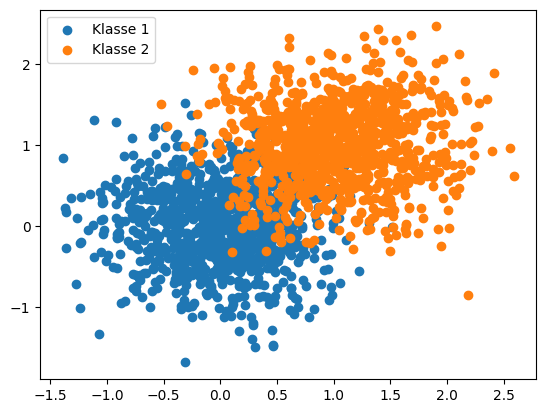

In [94]:
mean1 = [0, 0]
mean2 = [1, 1]
std = 0.5
n = 1000

c1 = np.random.normal(mean1, std, size=(n, 2))
c2 = np.random.normal(mean2, std, size=(n, 2))

x_set1, y_set1, x_train_set1, x_test_set1, y_train_set1, y_test_set1 = generate_dataset(c1=c1, c2=c2, test_size=0.3)

print(f'Size Training Data Set 1: {x_train_set1.shape[0]}')
print(f'Size Test Data Set 1: {x_test_set1.shape[0]}')

plot_scatter(c1=c1, c2=c2, c1_label='Klasse 1', c2_label='Klasse 2')

### Quadratischer Polynom-Klassifikator

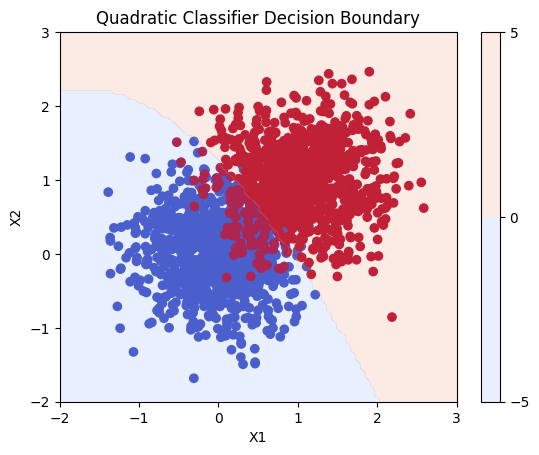

In [95]:
w = train_polynomial_classifier(x_train_set1, y_train_set1)
y_pred = np.round(quadratic_separator(x_test_set1[:, 0], x_test_set1[:, 1], w))

# Definiere Gitterpunkte zum Plotten
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
zz = np.round(quadratic_separator(xx.ravel(), yy.ravel(), w))

# Plotte Datenpunkte
plt.scatter(x_set1[:, 0], x_set1[:, 1], c=y_set1, cmap='coolwarm')

# Plotte Entscheidungsgrenze
plt.contourf(xx, yy, zz.reshape(xx.shape), levels=0, alpha=0.2, cmap='coolwarm')
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Quadratic Classifier Decision Boundary')
plt.show()


### Optimaler Threshold

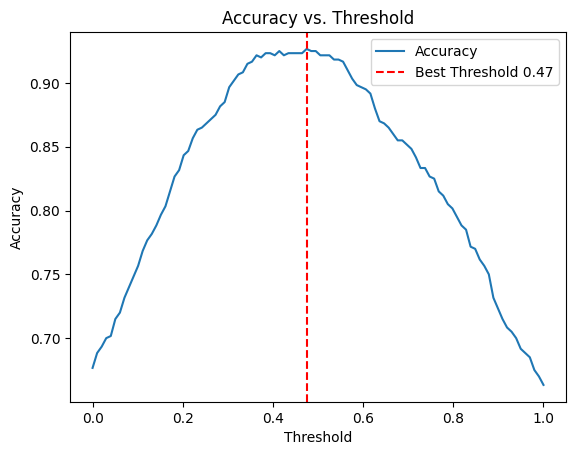

In [96]:
thresholds = np.linspace(0, 1, 100)

# Berechnung der Accuracy für jedes Threshold
accuracies = []
for t in thresholds:
    y_pred = predict(x_test_set1, w, threshold=t)
    accuracies.append(accuracy_score(y_test_set1, y_pred))

# Index des Thresholds mit höchster Accuracy
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]

# Plotte Accuracy vs. Threshold
plt.plot(thresholds, accuracies, label='Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold {round(best_threshold,2)}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

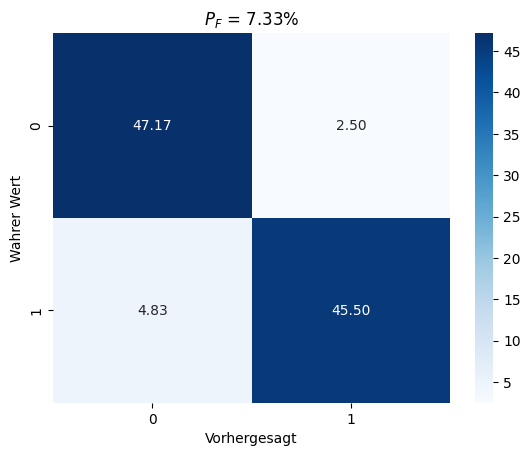

In [97]:
y_pred_set1_m1 = predict(x_test_set1, w, threshold=best_threshold)

cm_set1_m1, cm_set1_m1_prec, pf_set1_m1 = get_cm(y_test_set1, y_pred_set1_m1)
plot_cm(cm_set1_m1_prec, fr'$P_F$ = {pf_set1_m1:.2f}%')

## 2. Datensatz: Eine nicht unimodal verteilte Klasse

### Daten erzeugen und plotten

Size Training Data Set 2: 1400
Size Test Data Set 2: 600


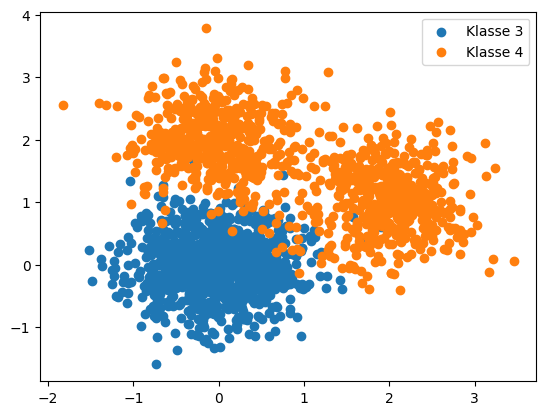

In [98]:
mean3 = [0, 0]

mean4_1 = [2, 1]
mean4_2 = [0, 2]

std = 0.5
n = 1000

c3 = np.random.normal(mean3, std, size=(n, 2))
class4_1 = np.random.normal(mean4_1, std, size=(int(n/2), 2))
class4_2 = np.random.normal(mean4_2, std, size=(int(n/2), 2))

c4 = np.concatenate([class4_1, class4_2], axis=0)

x_set2, y_set2, x_train_set2, x_test_set2, y_train_set2, y_test_set2 = generate_dataset(c1=c3, c2=c4, test_size=0.3)

print(f'Size Training Data Set 2: {x_train_set2.shape[0]}')
print(f'Size Test Data Set 2: {x_test_set2.shape[0]}')

plot_scatter(c1=c3, c2=c4, c1_label='Klasse 3', c2_label='Klasse 4')


### Quadratischer Polynom-Klassifikator

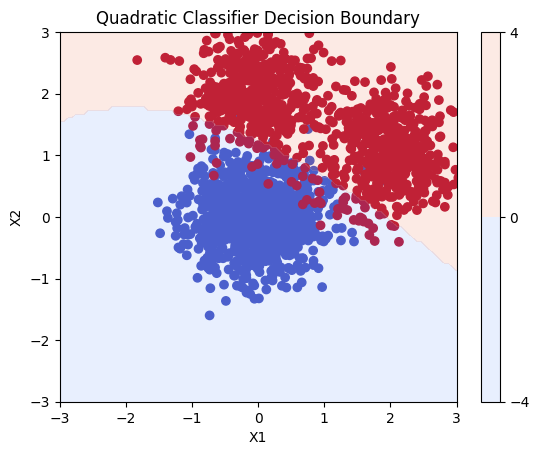

In [99]:
w = train_polynomial_classifier(x_train_set2, y_train_set2)
y_pred = np.round(quadratic_separator(x_test_set2[:, 0], x_test_set2[:, 1], w))

# Definiere Gitterpunkte zum Plotten
xx, yy = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
zz = np.round(quadratic_separator(xx.ravel(), yy.ravel(), w))

# Plotte Datenpunkte
plt.scatter(x_set2[:, 0], x_set2[:, 1], c=y_set2, cmap='coolwarm')

# Plotte Entscheidungsgrenze
plt.contourf(xx, yy, zz.reshape(xx.shape), levels=0, alpha=0.2, cmap='coolwarm')
plt.colorbar()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Quadratic Classifier Decision Boundary')
plt.show()

### Optimaler Threshold

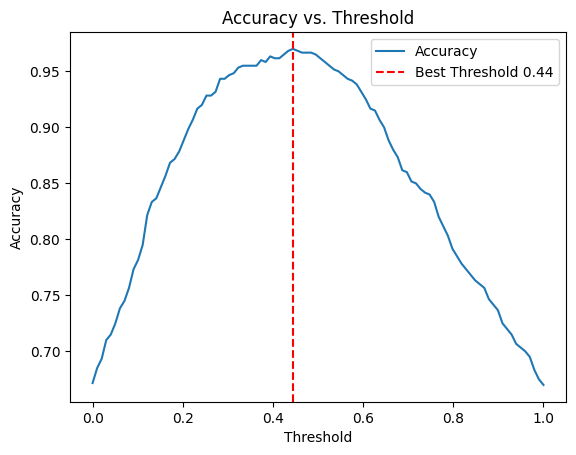

In [100]:
thresholds = np.linspace(0, 1, 100)

# Berechnung der Accuracy für jedes Threshold
accuracies = []
for t in thresholds:
    y_pred = predict(x_test_set2, w, threshold=t)
    accuracies.append(accuracy_score(y_test_set2, y_pred))

# Index des Thresholds mit höchster Accuracy
best_idx = np.argmax(accuracies)
best_threshold = thresholds[best_idx]
best_accuracy = accuracies[best_idx]

# Plotte Accuracy vs. Threshold
plt.plot(thresholds, accuracies, label='Accuracy')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold {round(best_threshold,2)}')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Threshold')
plt.legend()
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

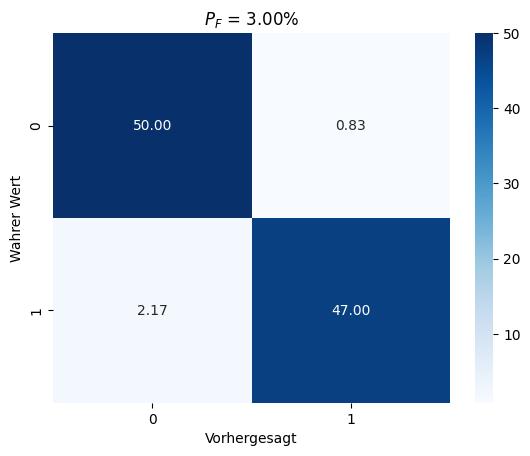

In [101]:
y_pred_set2_m1 = predict(x_test_set2, w, threshold=best_threshold)

cm_set2_m1, cm_set2_m1_prec, pf_set2_m1 = get_cm(y_test_set2, y_pred_set2_m1)
plot_cm(cm_set2_m1_prec, fr'$P_F$ = {pf_set2_m1:.2f}%')

# Aufgabe 3

## 1. Datensatz: Unimodal teilweise überlappend

### Logistische Regression

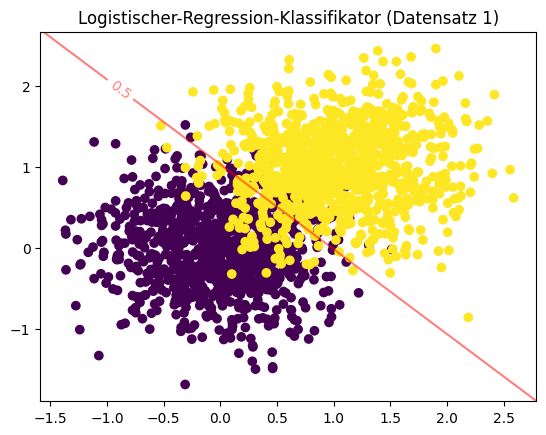

In [102]:
clf1 = LogisticRegression()
clf1.fit(x_train_set1, y_train_set1)

plt.figure()
plt.scatter(x_set1[:, 0], x_set1[:, 1], c=y_set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf1.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 1)')
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

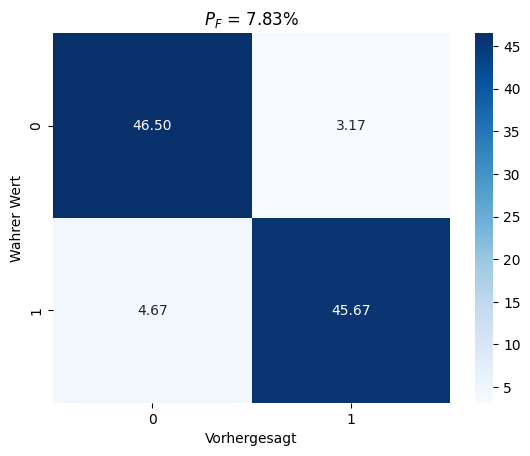

In [103]:
y_pred_set1_m2 = clf1.predict(x_test_set1)

cm_set1_m2, cm_set1_m2_prec, pf_set1_m2 = get_cm(y_test_set1, y_pred_set1_m2)

plot_cm(cm_set1_m2_prec, fr'$P_F$ = {pf_set1_m2:.2f}%')

### Logistische Regression mit quadratisch nichlinearer Transformation

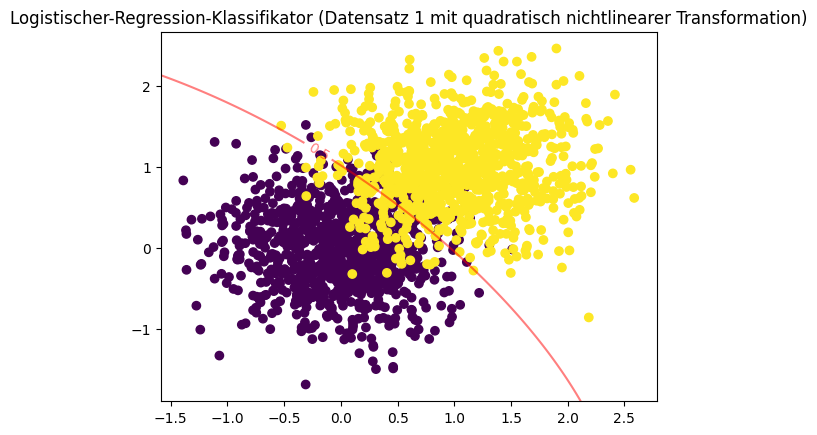

In [104]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_set1_transformed = poly.fit_transform(np.vstack([c1, c2]))

x_train_set1, x_test_set1, y_train_set1, y_test_set1 = train_test_split(x_set1_transformed, y_set1, test_size=0.3)

clf1 = LogisticRegression()
clf1.fit(x_train_set1, y_train_set1)

plt.figure()
plt.scatter(x_set1_transformed[:, 0], x_set1_transformed[:, 1], c=y_set1)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
xy = np.column_stack([xx.ravel(), yy.ravel()])
xy_transformed = poly.transform(xy)
Z = clf1.predict_proba(xy_transformed)[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 1 mit quadratisch nichtlinearer Transformation)')
plt.show()

### Fehlerwahrscheinlichkeit $P_F$

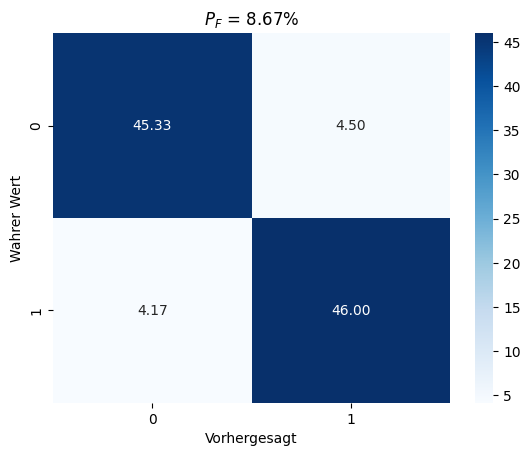

In [105]:
y_pred_set1_m3 = clf1.predict(x_test_set1)

cm_set1_m3, cm_set1_m3_prec, pf_set1_m3 = get_cm(y_test_set1, y_pred_set1_m3)

plot_cm(cm_set1_m3_prec, fr'$P_F$ = {pf_set1_m3:.2f}%')

## 2. Datensatz: Eine nicht unimodal verteilte Klasse

### Logistische Regression

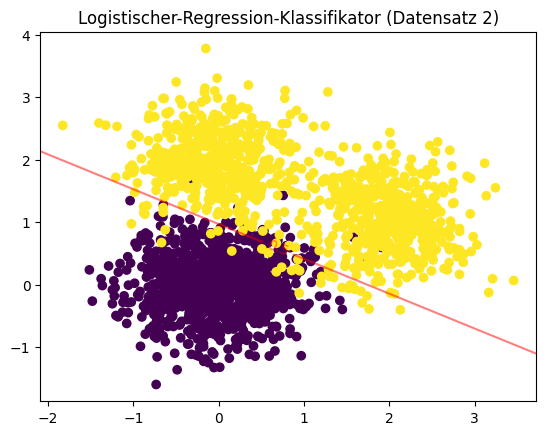

In [106]:
clf2 = LogisticRegression()
clf2.fit(x_train_set2, y_train_set2)

plt.figure()
plt.scatter(x_set2[:, 0], x_set2[:, 1], c=y_set2)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
Z = clf2.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 2)')
plt.show()

### Fehlerwahrscheinlichkeit $ P_F $

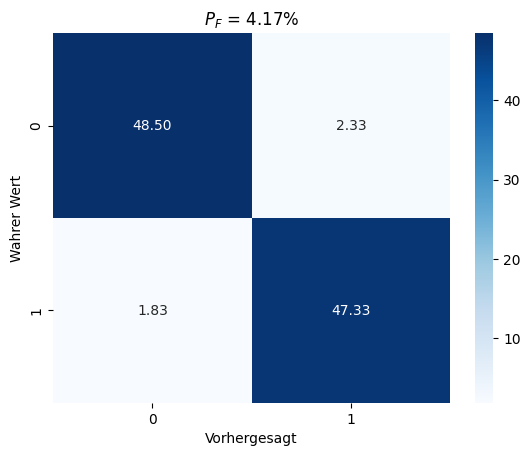

In [107]:
y_pred_set2_m2 = clf2.predict(x_test_set2)

cm_set2_m2, cm_set2_m2_prec, pf_set2_m2 = get_cm(y_test_set2, y_pred_set2_m2)

plot_cm(cm_set2_m2_prec, fr'$P_F$ = {pf_set2_m2:.2f}%')

### Logistische Regression mit quadratisch nichlinearer Transformation

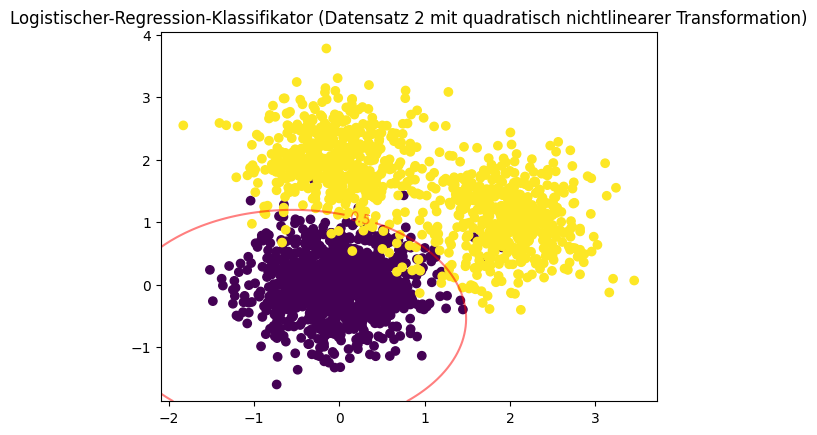

In [108]:
poly = PolynomialFeatures(degree=2, include_bias=False)
x_set2_transformed = poly.fit_transform(np.vstack([c3, c4]))

x_train_set2, x_test_set2, y_train_set2, y_test_set2 = train_test_split(x_set2_transformed, y_set2, test_size=0.3)

clf2 = LogisticRegression()
clf2.fit(x_train_set2, y_train_set2)

plt.figure()
plt.scatter(x_set2_transformed[:, 0], x_set2_transformed[:, 1], c=y_set2)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))
xy = np.column_stack([xx.ravel(), yy.ravel()])
xy_transformed = poly.transform(xy)
Z = clf2.predict_proba(xy_transformed)[:, 1]
Z = Z.reshape(xx.shape)

cs = ax.contour(xx, yy, Z, levels=[0.5], colors='red', alpha=0.5)
ax.clabel(cs, inline=1, fontsize=10)

plt.title('Logistischer-Regression-Klassifikator (Datensatz 2 mit quadratisch nichtlinearer Transformation)')
plt.show()

### Fehlerwahrscheinlihckeit $P_F$

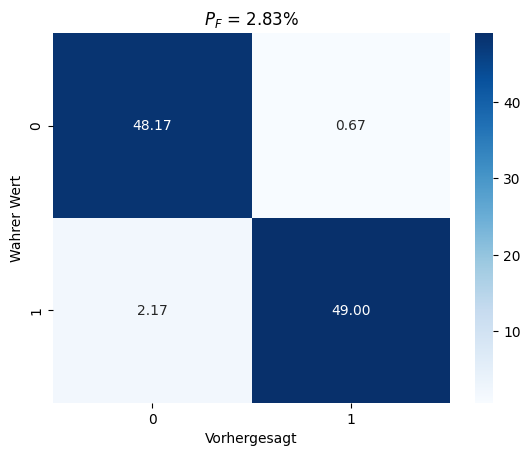

In [109]:
y_pred_set2_m3 = clf2.predict(x_test_set2)

cm_set2_m3, cm_set2_m3_prec, pf_set2_m3 = get_cm(y_test_set2, y_pred_set2_m3)

plot_cm(cm_set2_m3_prec, fr'$P_F$ = {pf_set2_m3:.2f}%')

## Wie werden die Parameter über eine Optimierung bestimmt?

Die Parameter einer logistischen Regression werden über eine Optimierung bestimmt, indem die negativ logarithmierte Likelihood-Funktion numerisch minimiert wird.

Dies geschieht in der Regel mit Hilfe von Optimierungsalgorithmen, die den Gradienten der Funktion nutzen, um die Richtung der Parameteraktualisierung zu bestimmen. Ein weit verbreiteter Algorithmus ist zum Beispiel der Gradientenabstieg. Dabei wird ein Anfangswert für die Parameter festgelegt und iterativ so angepasst, dass die negativ logarithmierte Likelihood-Funktion minimiert wird. Die Iterationen werden fortgesetzt, bis ein Abbruchkriterium erreicht ist oder eine vorgegebene Anzahl von Iterationen durchgeführt wurde.

Ziel ist es, die Parameter so zu bestimmen, dass die Wahrscheinlichkeit, die beobachteten Daten zu erklären, maximiert wird. Dies bedeutet, dass das Modell in der Lage ist, die Beziehung zwischen den Eingangsdaten und den Zielvariablen so gut wie möglich zu modellieren und damit eine Vorhersage für neue, unbekannte Datenpunkte machen kann.

## Vergleich der Modelle

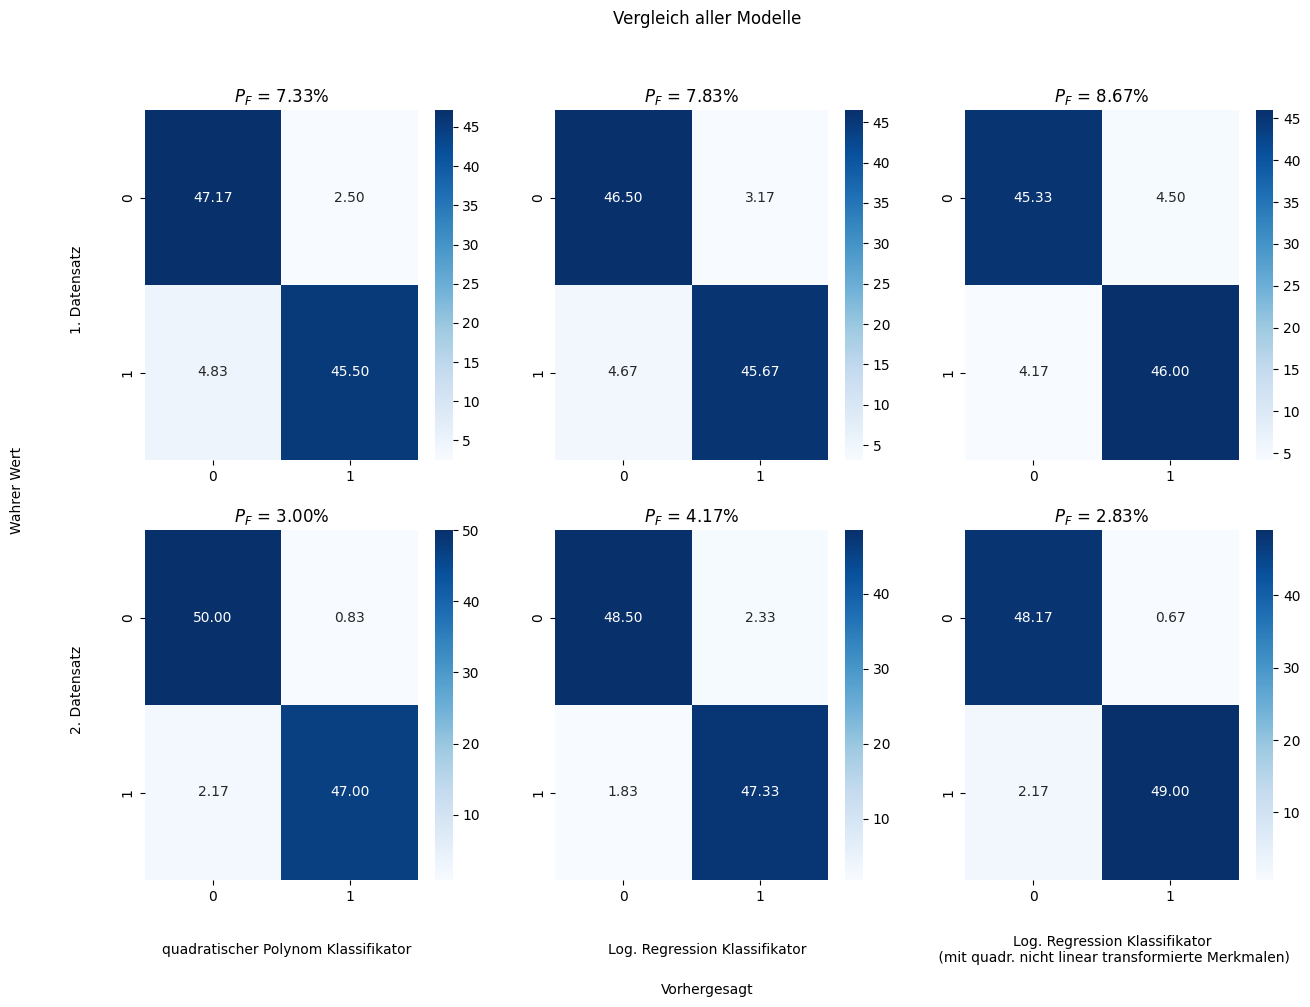

In [110]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

sns.heatmap(cm_set1_m1_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[0, 0])
ax[0,0].set_title(fr'$P_F$ = {pf_set1_m1:.2f}%')

sns.heatmap(cm_set1_m2_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[0, 1])
ax[0,1].set_title(fr'$P_F$ = {pf_set1_m2:.2f}%')

sns.heatmap(cm_set1_m3_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[0, 2])
ax[0,2].set_title(fr'$P_F$ = {pf_set1_m3:.2f}%')

sns.heatmap(cm_set2_m1_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[1, 0])
ax[1,0].set_title(fr'$P_F$ = {pf_set2_m1:.2f}%')

sns.heatmap(cm_set2_m2_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[1, 1])
ax[1,1].set_title(fr'$P_F$ = {pf_set2_m2:.2f}%')

sns.heatmap(cm_set2_m3_prec, annot=True, fmt='.2f', cmap='Blues', ax=ax[1, 2])
ax[1,2].set_title(fr'$P_F$ = {pf_set2_m3:.2f}%')

fig.suptitle('Vergleich aller Modelle')

fig.text(0.5, 0, 'Vorhergesagt', ha='center', va='center')

fig.text(0.22, 0.04, 'quadratischer Polynom Klassifikator', ha='center', va='center')
fig.text(0.5, 0.04, 'Log. Regression Klassifikator', ha='center', va='center')
fig.text(0.77, 0.04, 'Log. Regression Klassifikator\n (mit quadr. nicht linear transformierte Merkmalen)', ha='center', va='center')

fig.text(0.04, 0.5, 'Wahrer Wert', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.3, '2. Datensatz', ha='center', va='center', rotation='vertical')
fig.text(0.08, 0.7, '1. Datensatz', ha='center', va='center', rotation='vertical')

plt.show()